In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from itertools import product, groupby, chain, compress
from scipy.stats import ttest_ind, pearsonr, hmean
from sklearn import metrics as mtr
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox, AnchoredText)
import matplotlib_venn as venn
import warnings
warnings.filterwarnings("ignore")

In [2]:
def parse_fasta(fasta):
    faiter = (x[1] for x in groupby(fasta, lambda line: line.startswith(">")))
    for header in faiter:
        yield next(header)[1:].strip(), "".join(s.strip() for s in next(faiter))

In [3]:
def names(fname):
    names = json.load(open("data/caid_names.json"))

    name = names.get(fname)
    if name is None:
        fname = fname.lower()
        if "cons" in fname:
            name = "Naive Conservation"
        elif "pdb" in fname and 'reverse' in fname:
            name = "Naive PDB"
        elif "gene3d" in fname and 'reverse' in fname:
            name = "Naive Gene3D"
        elif "random" in fname:
            name = "Random"
        elif "dataset" in fname:
            name = "Shuffled dataset"
        elif "target" in fname:
            name = "Shuffled targets"
        elif "fix" in fname:
            name = "Fixed ID content"
        elif "ref" in fname:
            name = "Reference"
    return name
    

In [4]:
dataset_names = {
    'disprot-disorder': 'DisProt',
    'disprot-disorder-pdb-atleast': 'DisProt-PDB',
    'disprot-binding': 'DisProt-Binding',
    'disprot-binding-all': 'DisProt-Binding-All',
    'disprot-binding-disorder': 'DisProt-Binding-Disorder'
}

In [5]:
caidfolder = Path("/home/marnec/Projects/CAID/")
datadir = Path("/home/marnec/Projects/CAID/data/")

## Display element 1 - CAID
Drafted, refinements needed

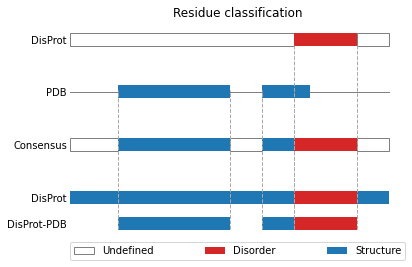

In [6]:
def draw_consensus_schema(ax, lbl=None):
    ax.set(title="Residue classification")
    colm = 'w'
    cold = 'C3'
    cols = 'C0'
    colu = 'w' 
    h = .5

    regs = [[[70, 20, 10]], #[70, 15, 15]],                   # disprot
            [[15, 35, 10, 15, 25]], #[22, 43, 35]],         # pdb
            [[15, 35, 10, 10, 0, 20, 10]],                   # consensus 
            [[70, 20, 10], [15, 35, 10, 10, 0, 20, 10]]]     # ground truth

    groups = np.hstack([[i]*len(g) for i,g in enumerate(regs)])
    groupn = [len(r) for r in regs]
    regs = [r for g in regs for r in g]
    lefts = [np.cumsum([0] + r[:-1]) for r in regs]
    ys = [-1*np.full((len(r), ), i) for i, r in enumerate(regs)]
    ys = [y-i for i, y in zip(groups, ys)]

    colors = [[colu, cold, colu],# [colu, cold, colu],
              [colu, cols, colu, cols, colu], #[colu, cols, colu],
              [colu, cols, colu, cols, colu, cold, colu],
              [cols, cold, cols],
              [colm, cols, colm, cols, colm, cold, colm]]
    
    linewidths = [1, 0, 1,
                 0, 0, 0, 0, 0,# 0, 0, 0,
                 1, 0, 1, 0, 1, 0, 1,
                 0, 0, 0,
                 0, 0, 0, 0, 0, 0, 0]
    
    rects = ax.barh(
        np.hstack(ys), 
        np.hstack(regs), 
        height=h,
        left=np.hstack(lefts), 
        color=np.hstack(colors),
        linewidth=linewidths,
        edgecolor="grey")
    
    for y, r, l in zip(ys[1:3], regs[1:2], lefts[1:2]):
        y = y.tolist()
        y = [y[0]] + y
        for yy, rr, ll in list(zip(y, r, l))[::2]:
            ax.axhline(yy, xmin=ll/105, xmax=(ll + rr)/105, color='grey', linewidth=1)
    
    for x, y in zip(np.cumsum(regs[-1][:-1]), [.74, .74, .74, .74, 0.95, 0.95]):
        ax.axvline(x, ymin=0.05, ymax=y-0.05, linestyle="--", linewidth=1, color='darkgrey')

    ax.set_yticks(np.unique(np.hstack(ys))[::-1]);
    ax.set_yticklabels(["DisProt", #"DisProt 2", 
                        "PDB", #"PDB 2",
                        "Consensus", 
                        "DisProt", 
                        "DisProt-PDB"]);
    groupl = ["DisProt", "PDB", "", "Ground truth"]

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
 
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    j=0
    for i, l in zip(np.cumsum(groupn), groupl):
        y = np.unique(np.hstack(ys[j:i])).mean()
#         ax.text(103, y, l)
        j=i
    
    ax.legend([Patch(facecolor=colu, edgecolor="grey"), 
               Patch(facecolor=cold), 
               Patch(facecolor=cols)], 
              ['Undefined', "Disorder", "Structure"], 
              bbox_to_anchor=(0.,-0.1, 1., .102), 
              loc='center left', ncol=3, mode="expand", borderaxespad=0.)
    ax.tick_params(axis='y', which='both', length=0)
    ax.get_xaxis().set_visible(False)
    
    if lbl is not None:
        ax.text(-0.15, 1.05, lbl, transform=ax.transAxes, size=20, weight='bold')
    
fig, ax = plt.subplots()
draw_consensus_schema(ax)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (3).

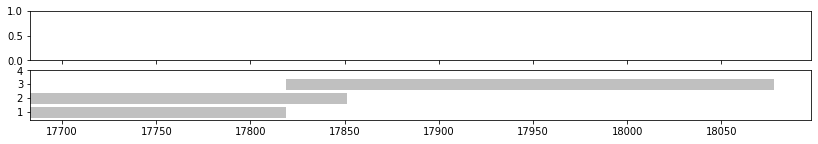

In [7]:
def draw_caid_timeline(ax, names=None, dates=None, lbl=None):
    ax, ax2 = ax
    names = ["CAID announcement", "CASP", "Submission deadline", "ISMB", ""]

    dates = ["2018-06-01", "2018-12-04", "2018-10-15", "2019-07-01", "2020-01-01"]
    
    periods = [
               ("Software installation", "2018-06-01", "2018-10-15"),
               ("Evidence accumulation", "2018-06-01", "2018-11-16"),
               ("Analysis", "2018-10-15", "2019-07-01")]
    
    dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
    for i, (event, startdate, enddate) in enumerate(periods, 1):
        startdate, enddate = datetime.strptime(startdate,"%Y-%m-%d"), datetime.strptime(enddate, "%Y-%m-%d")
        ax2.barh(i, [enddate - startdate], left=[startdate], color="silver")
#         ax2.text(enddate, i, event, va="center", ha="left")
    ax2.set_yticks(range(1, 5))
    ax2.set_yticklabels(list(zip(*periods))[0])
    ax2.invert_yaxis()

    # Choose some nice levels
    levels = np.tile([3, 1, 2, 1, 0],
                     int(np.ceil(len(dates)/6)))[:len(dates)]

    markerline, stemline, baseline = ax.stem(dates, levels,
                                             linefmt="C3-", basefmt="k-",
                                             use_line_collection=True)

    plt.setp(markerline, mec="k", mfc="w", zorder=3, markevery=slice(0, len(dates)-1, 1))
    
    markerline, stemline, baseline = ax.stem([dates[-1]], [0],
                                             linefmt="C3-", basefmt="k-", markerfmt='>',
                                             use_line_collection=True)
    
    plt.setp(markerline, mec="k", mfc="w", zorder=4)
    
    # annotate lines
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    for d, l, r, va in zip(dates, levels, names, vert):
        ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                    textcoords="offset points", va=va, ha="left")

    # format xaxis with 4 month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="left")

    # remove y axis and spines
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
    for spine in ["left", "top", "right", "bottom"]:
        ax.spines[spine].set_visible(False)
        
    for spine in ["left", "top", "right"]:
        ax2.spines[spine].set_visible(False)
    

    ax.margins(y=0.1)
    ax2.tick_params(axis='y', which='both', length=0)
    ax2.tick_params(axis='x', which='minor', length=0)
    ax2.set_xlim(datetime.strptime("2018-05-20", "%Y-%m-%d"), datetime.strptime("2020-01-10", "%Y-%m-%d"))
    
    if lbl is not None:
        ax.text(-0.15, 1.05, lbl, transform=ax.transAxes, size=20, weight='bold')
    

fig, ax = plt.subplots(2, 1, figsize=(14, 2), sharex=True)
draw_caid_timeline(ax)

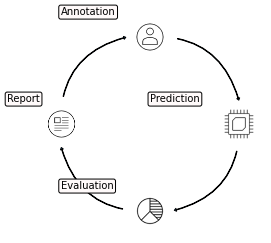

In [8]:
def draw_caid_process(ax, round=False, plotlbl=None):
#     ax.set_title("CAID process")
    images = ["/home/marnec/Projects/CAID/caid/data/img/users.png",  
              "/home/marnec/Projects/CAID/caid/data/img/article2.png", 
              "/home/marnec/Projects/CAID/caid/data/img/evaluation2.png",
              "/home/marnec/Projects/CAID/caid/data/img/server2.png"][::-1]
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    labels = ['Prediction', 'Evaluation', 'Report', 'Annotation']
    style="Simple,head_length=0.2,head_width=0.3,tail_width=0.05"
    
    if round is True:
        y = np.array([0.1, 0.5, 0.9, 0.5])
    else: 
        y = np.array([0.3, 0.3, 0.7, 0.7])
        
    x = np.roll(y, 1)
    arrow_xy = np.squeeze(np.dstack([x, y]))
    box_xy = np.squeeze(np.roll(np.dstack([x, y]), 1, axis=1))
    
    if round is True:
        ey = [0, -0.1, 0, 0.1]
        ex = np.roll(ey, -3)
    else:
        ey = [.05, 0, -.05, 0]
        ex = np.roll(ey, 1)
    
    errs = np.squeeze(np.dstack([ex, ey]))
    
    for i, (img, axy, bxy, err, lbl) in enumerate(zip(images, arrow_xy, box_xy, errs, labels), 1):
        arr_img = plt.imread(img, format='png')
        imagebox = OffsetImage(arr_img, zoom=0.5)
        cnstyle = 'arc3,rad=-0.4' if round is True else 'arc3'
        ab = AnnotationBbox(imagebox, axy+err, frameon=False, xybox=bxy, pad=0, arrowprops=dict(arrowstyle=style,connectionstyle=cnstyle))
        ax.add_artist(ab)
        ax.text(*bxy+np.array([-(0.04*len(lbl)), 0.1]), lbl, bbox=dict(boxstyle="round,pad=0.2,rounding_size=0.2", fc='snow'), zorder=4)
        
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    
    if plotlbl is not None:
        ax.text(-0.15, 1.05, plotlbl, transform=ax.transAxes, size=20, weight='bold')

fig, ax = plt.subplots(figsize=(4,4))
draw_caid_process(ax, round=True)

In [9]:
def draw_proteins_venn(ax, tgtstats, lbl=None):
    old_disprot_entries = {h.split('|')[1] for h, s in parse_fasta(open('../data/annotations/disprot-2016-10-disorder.fasta'))}
    disprot_entries = {h for h, s in parse_fasta(open('../data/references/disorder/disprot-disorder.txt'))}
    pdb_entries = {h.split('|')[0] for h, s in parse_fasta(open('../data/annotations/pdb_atleast.fasta')) if set(s) - {'-'}} - old_disprot_entries
    binding_entries = {h for h, s in parse_fasta(open('../data/references/binding/disprot-binding.txt'))}
        
    venn.venn3([disprot_entries, pdb_entries, binding_entries], ['DisProt', 'PDB', 'Binding'], ax=ax)
    if lbl is not None:
        ax.text(-0.15, 1.05, lbl, transform=ax.transAxes, size=20, weight='bold')
    
    ax.set_title("Proteins")

In [10]:
def draw_taxon_pie(ax, tgtstats, dataset, lbl=None):
    t = tgtstats.loc[dataset].data.groupby('taxon').count()
    ax.pie(t.species, autopct='%1.1f%%', labels=t.index)
    ax.add_artist(plt.Circle((0,0),0.70,fc='white'))
    ax.set_title("Taxon")
    if lbl is not None:
        ax.text(-0.15, 1.05, lbl, transform=ax.transAxes, size=20, weight='bold')

In [11]:
def powticks(x, pos):
    if x == 0: return "$0$"
    exponent = int(np.log10(x))
    coeff = x/10**exponent
    return r"${:2.0f} \times 10^{{ {:2d} }}$".format(coeff,exponent)

def draw_residues_bar(ax, tgtstats, lbl=None):
    tgtstats.residues.groupby(level=0).sum().drop('total', axis=1).loc[dataset_sorting].plot.barh(stacked=True, ax=ax)
    ax.set_title("Residues")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(powticks))
    ax.invert_yaxis()
    ax.tick_params(axis='x', labelsize=7)
    if lbl is not None:
        ax.text(-0.15, 1.05, lbl, transform=ax.transAxes, size=20, weight='bold')

In [12]:
def draw_content_boxplot(ax, tgtstats, lbl=None):
    tgtstats.data.idc.unstack().T[dataset_sorting].plot.box(vert=False, ax=ax, showfliers=False)
    ax.invert_yaxis()
    ax.set_title('ID/Binding content')
    if lbl is not None:
        ax.text(-0.15, 1.05, lbl, transform=ax.transAxes, size=20, weight='bold')

In [13]:
def draw_plen_boxplot(ax, tgtstats, lbl=None):
    (tgtstats.residues.total - tgtstats.residues.undefined).unstack().T[dataset_sorting].plot.box(vert=False, ax=ax, showfliers=False)
    ax.set_title('Protein length')
    ax.set_xlabel(None)
    ax.get_yaxis().set_visible(False)
    ax.invert_yaxis()
    if lbl is not None:
        ax.text(-0.15, 1.05, lbl, transform=ax.transAxes, size=20, weight='bold')

In [14]:
def draw_rlen_boxplot(ax, regstats, lbl=None):
    regstats[regstats.type=='1'].length.unstack().unstack().T[dataset_sorting].plot.box(showfliers=False, vert=False, ax=ax)
    ax.set_title('Region length')
    plt.gcf().suptitle(None)
    ax.set_xlabel(None)
    ax.invert_yaxis()
    ax.get_yaxis().set_visible(False)
    if lbl is not None:
        ax.text(-0.15, 1.05, lbl, transform=ax.transAxes, size=20, weight='bold')

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (3).

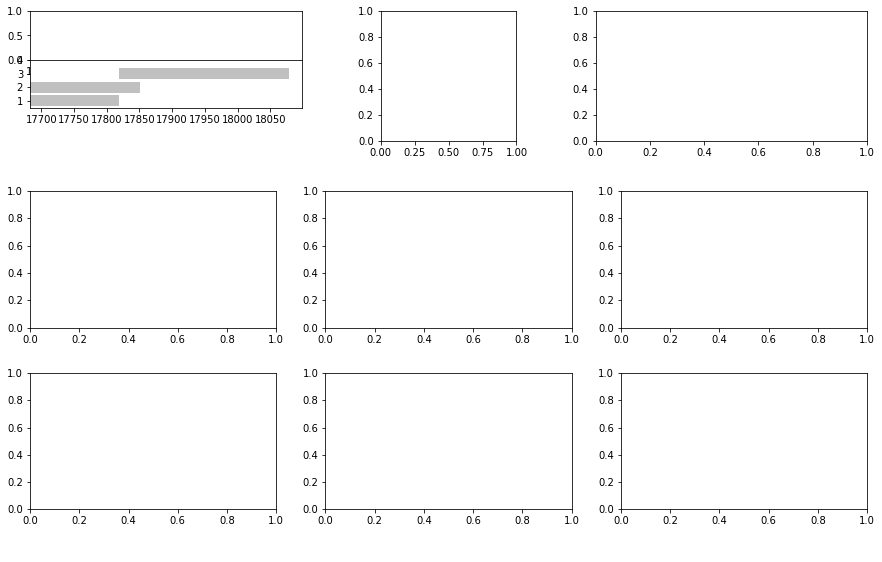

In [15]:
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(4, 3, bottom=0.7, hspace=0, width_ratios=[2, 1, 2], wspace=0.35, height_ratios=[0,3,3,2])

fakeaxt = fig.add_subplot(gs[0, :])
fakeaxt.get_yaxis().set_visible(False)
fakeaxt.get_xaxis().set_visible(False)
fakeaxt.axis('off')

ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[1:, 1])
ax4 = fig.add_subplot(gs[1:, 2])
gs = fig.add_gridspec(3, 3, top=0.63, hspace=0.5, height_ratios=[1,1,0])
ax5 = fig.add_subplot(gs[0, 0])
ax6 = fig.add_subplot(gs[0, 1])
ax7 = fig.add_subplot(gs[0, 2])
ax8 = fig.add_subplot(gs[1, 0])
ax9 = fig.add_subplot(gs[1, 1])
ax10 = fig.add_subplot(gs[1, 2])

fakeaxb = fig.add_subplot(gs[2, :])
fakeaxb.get_yaxis().set_visible(False)
fakeaxb.get_xaxis().set_visible(False)
fakeaxb.axis('off')


excluded_datasets = ['DisProt-Binding', 'DisProt-Binding-Disorder']
dataset_sorting = ['DisProt', 'DisProt-PDB', 'DisProt-Binding-All']
tstats = pd.read_csv('../data/dataset_stats/references-stats.target.csv', index_col=[0,1], header=[0,1]).rename(dataset_names, level=0).drop(excluded_datasets, level=0)
rstats = pd.read_csv('../data/dataset_stats/references-stats.region.csv', index_col=[0,1,2]).rename(dataset_names, level=0).drop(excluded_datasets, level=0)

draw_caid_timeline(ax=[ax1, ax2], lbl='A')
draw_caid_process(ax=ax3, round=True, plotlbl='B')
draw_consensus_schema(ax=ax4, lbl='C')
draw_residues_bar(ax5, tstats, lbl='D')
draw_proteins_venn(ax6, tstats, lbl='E')
draw_taxon_pie(ax7, tstats, 'DisProt', lbl='F')
draw_content_boxplot(ax8, tstats, lbl='G')
draw_plen_boxplot(ax9, tstats)
draw_rlen_boxplot(ax10, rstats)

# gs.tight_layout(fig, rect=(1, 1, 1, 1))
plt.savefig("../manuscript/fig1.png", dpi=300, bbox_inches='tight')

## Display element 2 - F1-Score and Precision Recall Curves

In [16]:
excluded_methods_disorder = ["IUPred-short", "IUPred-long", 'SPOT-Disorder1']
excluded_methods_binding = ["ANCHOR"]

In [17]:
from scipy import stats

def confidence_interval(series, interval=0.95):
    mean = series.mean()
    n = series.count()
    test_stat = stats.t.ppf((interval + 1)/2, n)
    norm_test_stat = (test_stat * series.std()) / (n ** 0.5)
    lower_bound = mean - norm_test_stat
    upper_bound = mean + norm_test_stat
    return upper_bound - lower_bound

In [18]:
def get_bar_data_dataset(dataset, excluded_methods, first=10, mtr='f1s'):
    metrics_dataset_preds = pd.read_csv(caidfolder / "results/{}.analysis.all.dataset.{}.metrics.csv".format(dataset, mtr), index_col=[0])
    metrics_dataset_npdbr = pd.read_csv(caidfolder / "baseline/{}.naive-pdb-atleast-reverse.all.dataset.{}.metrics.csv".format(dataset, mtr), index_col=[0])
    metrics_dataset_ngen3 = pd.read_csv(caidfolder / "baseline/{}.naive-gene3d-reverse.all.dataset.{}.metrics.csv".format(dataset, mtr), index_col=[0])
    metrics_dataset_nfixf = pd.read_csv(caidfolder / "baseline/{}.fixedposfrc.all.dataset.{}.metrics.csv".format(dataset, mtr), index_col=[0])
    metrics_dataset_randm = pd.read_csv(caidfolder / "baseline/{}.random.all.dataset.{}.metrics.csv".format(dataset, mtr), index_col=[0])
    metrics_dataset_shudt = pd.read_csv(caidfolder / "baseline/{}.shuffledataset.all.dataset.{}.metrics.csv".format(dataset, mtr), index_col=[0])
    metrics_dataset_cons = pd.read_csv(caidfolder / "baseline/{}.cons.all.dataset.{}.metrics.csv".format(dataset, mtr), index_col=[0])
#     metrics_dataset_idcnt = pd.read_csv(caidfolder / "baseline/{}.shuffletargets.all.dataset.{}.metrics.csv".format(dataset, mtr), index_col=[0])
    
    bootstrap_dataset_preds = pd.read_csv(caidfolder / "results/{}.analysis.all.bootstrap.{}.metrics.csv".format(dataset, mtr), index_col=[0,1])
    bootstrap_dataset_npdbr = pd.read_csv(caidfolder / "baseline/{}.naive-pdb-atleast-reverse.all.bootstrap.{}.metrics.csv".format(dataset, mtr), index_col=[0,1])
    bootstrap_dataset_ngen3 = pd.read_csv(caidfolder / "baseline/{}.naive-gene3d-reverse.all.bootstrap.{}.metrics.csv".format(dataset, mtr), index_col=[0,1])
    bootstrap_dataset_cons = pd.read_csv(caidfolder / "baseline/{}.cons.all.bootstrap.{}.metrics.csv".format(dataset, mtr), index_col=[0,1])
#     bootstrap_dataset_nfixf = pd.read_csv(caidfolder / "baseline/{}.fixedposfrc.all.bootstrap.{}.metrics.csv".format(dataset, mtr), index_col=[0])
#     bootstrap_dataset_idcnt = pd.read_csv(caidfolder / "baseline/{}.shuffletargets.all.bootstrap.{}.metrics.csv".format(dataset, mtr), index_col=[0])
    
    dataset_std = bootstrap_dataset_preds.append(bootstrap_dataset_ngen3).append(bootstrap_dataset_npdbr).append(bootstrap_dataset_cons)[mtr].groupby(level=0).std().rename(names)
    dataset_std.loc[names('random')] = metrics_dataset_randm[mtr].std()
    dataset_std.loc[names('shuffledataset')] = metrics_dataset_shudt[mtr].std()
    dataset_stderr = dataset_std / len(bootstrap_dataset_preds.index.get_level_values(1).unique()) ** 0.5

    ci_dataset_preds = pd.read_csv(caidfolder / "results/{}.analysis.all.ci.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1]).xs(mtr, level=1)
    ci_dataset_npdbr = pd.read_csv(caidfolder / "baseline/{}.naive-pdb-atleast-reverse.all.ci.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1]).xs(mtr, level=1)
    ci_dataset_ngen3 = pd.read_csv(caidfolder / "baseline/{}.naive-gene3d-reverse.all.ci.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1]).xs(mtr, level=1)
    ci_dataset_cons = pd.read_csv(caidfolder / "baseline/{}.cons.all.ci.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1]).xs(mtr, level=1)
  
    dataset_ci = ci_dataset_preds.append(ci_dataset_npdbr).append(ci_dataset_ngen3).append(ci_dataset_cons).rename(names).drop('thr', axis=1).diff(axis=1)['hi']
    dataset_ci.loc[names('random')] = confidence_interval(metrics_dataset_randm[mtr])
    dataset_ci.loc[names('shuffledataset')] = confidence_interval(metrics_dataset_shudt[mtr])
    
    mtr_dataset_preds = metrics_dataset_preds[mtr].sort_values(ascending=False).rename(names).drop(excluded_methods).head(first)
    
    mtr_dataset_base = metrics_dataset_ngen3.rename(names)[mtr]\
        .append(metrics_dataset_npdbr\
        .append(metrics_dataset_cons)\
                .rename(names)[mtr])
    
    mtr_dataset_base.loc[names('random')] = metrics_dataset_randm[mtr].mean()
    mtr_dataset_base.loc[names('shuffledataset')] = metrics_dataset_shudt[mtr].mean()
    
    mtr_dataset_base = mtr_dataset_base.sort_values(ascending=False)
    mtr_dataset = pd.concat([mtr_dataset_preds.append(mtr_dataset_base), dataset_stderr, dataset_ci], axis=1, join='inner')
    mtr_dataset.columns = ['y', 'err', 'ci']
    
    return mtr_dataset, mtr_dataset_base.max()

In [19]:
def get_bar_data_target(dataset, excluded_methods, first=10, mtr='f1s'):
    metrics_target_preds = pd.read_csv(caidfolder / "results/{}.analysis.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
    metrics_target_npdbr = pd.read_csv(caidfolder / "baseline/{}.naive-pdb-atleast-reverse.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
    metrics_target_ngen3 = pd.read_csv(caidfolder / "baseline/{}.naive-gene3d-reverse.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
    metrics_target_cons = pd.read_csv(caidfolder / "baseline/{}.cons.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
#     metrics_target_nfixf = pd.read_csv(caidfolder / "baseline/{}.fixedposfrc.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
#     metrics_target_idcnt = pd.read_csv(caidfolder / "baseline/{}.shuffletargets.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
    
    mtr_target_preds = metrics_target_preds[mtr].groupby(level=0).describe()[["mean", "std"]].sort_values("mean",ascending=False)
    mtr_target_base = pd.concat(
        [metrics_target_ngen3[mtr].describe()[["mean", "std"]].to_frame().T.rename({mtr: "Naive Gene3D"}),
         metrics_target_npdbr[mtr].describe()[["mean", "std"]].to_frame().T.rename({mtr: "Naive PDB"}),
         metrics_target_cons[mtr].describe()[["mean", "std"]].to_frame().T.rename({mtr: "Naive Conservation"}),
#          metrics_target_idcnt[mtr].describe()[["mean", "std"]].to_frame().T.rename({mtr: "Shuffled Targets"})
        ],
        sort=False).sort_values("mean", ascending=False)
    
    mtr_target = mtr_target_preds.rename(names).drop(excluded_methods).head(10).append(mtr_target_base)
    mtr_target['std'] = mtr_target['std'] / len(metrics_target_preds.index.get_level_values(1).unique()) ** 0.5
    return mtr_target.rename({'mean':'y', 'std':'err'}, axis=1), mtr_target_base['mean'].max()

In [20]:
def plot_bars(ax, data, baseliney, ylabel, axtitle, plotlbl='A'):
#     c10 = cm.get_cmap('tab10')
    ax = data['y'].plot.bar(ax=ax, color=['silver']*10 + (["w"]*(len(data)-10)), yerr=data['err'],
                           linewidth=[0]*10 + [1]*(len(data)-10), edgecolor='k')
    _ = ax.axhline(baseliney, linewidth=1, linestyle='--')
    _ = ax.set_ylabel(ylabel)
    ax.title.set_text(axtitle)
    ax.set_ylim(0,1)
    ax.text(-0.15, 1.05, plotlbl, transform=ax.transAxes, size=20, weight='bold')
    ax.get_xaxis().set_visible(False)

In [106]:
def plot_cput(ax, predictors, plotlbl='B'):
    cputime = pd.read_csv('../data/dataset_stats/cpu_time.csv', index_col=0, header=[0,1])
    order = ['prediction', 'hhblits', 'psiblast']

    cputime = cputime.groupby(level=0, axis=1).sum().rename(names, axis=1).reindex(predictors, axis=1)
       
    cputime.boxplot(rot=90, 
                    ax=ax, 
                    grid=False, 
                    flierprops=dict(marker=',', markerfacecolor='steelblue', markeredgecolor='none', alpha=.1),
                    boxprops=dict(alpha=.7))
    
    cputimelessthanone = pd.Series(np.nan, index=cputime.median().index)
    cputimelessthanone[cputime.median()<0.1] = 1
    ax.plot(np.arange(len(cputimelessthanone))+1, cputimelessthanone.values, marker='o', markersize=5, color='magenta')
    
    ax.set_yscale('log')
    ax.set_ylabel('$\log_{10}(Seconds)$')
    ax.text(-0.15, 1.05, plotlbl, transform=ax.transAxes, size=20, weight='bold')
    ax.set_xlabel(None)
    ax.set_yticks(10**np.linspace(0, 4, 5))
    ax.grid(which='major', axis='both', alpha=.1)
    ax.set_ylim(0.5, 10**4)
    ax.xaxis.set_tick_params(rotation=90)
    
# plot_cput(plt.axes(), get_bar_data_dataset('disprot-disorder-pdb-atleast', excluded_methods_disorder)[0].index)

In [107]:
def plot_pr(ax, dataset, excluded_methods, plotlbl='C'):

    pred_prs = pd.read_csv("../results/{}.analysis.all.dataset._.pr.csv".format(dataset), index_col=[0], header=[0, 1, 2, 3]).rename(names, axis=1, level=0).drop(excluded_methods, axis=1, level=0)
    pdb_prc = pd.read_csv("../baseline/{}.naive-pdb-atleast-reverse.all.dataset._.pr.csv".format(dataset), index_col=[0], header=[0, 1, 2, 3])
    gene3d_prc = pd.read_csv("../baseline/{}.naive-gene3d-reverse.all.dataset._.pr.csv".format(dataset), index_col=[0], header=[0, 1, 2, 3])
    cons_prc = pd.read_csv('../baseline/{}.cons.all.dataset._.pr.csv'.format(dataset), index_col=[0], header=[0, 1, 2, 3])
    random_prcs = [pd.read_csv('../baseline/{}.{}.all.target.mcc.metrics.csv'.format(dataset, b), index_col=0)
                        for b in ["random", "shuffledataset"]]

    cov = pd.read_csv('../results/{}.analysis.all.target.default.metrics.csv'.format(dataset), index_col=[0,1], header=[0,1])
    cov = (cov.groupby(level=0).count().max(axis=1) / np.max(cov.groupby(level=0).count().values))

    sorter = sorted(((p, hmean(pred_prs[p].dropna().values, axis=1).max().round(2)) for p in pred_prs.columns.get_level_values(0).unique()),
                     key=lambda t: t[1], reverse=True)

    # select first 10 predictors (based on AUC)
    prcs = pred_prs.reindex(list(zip(*sorter))[0], axis=1, level=0)

    # plot f-score level lines
    r = np.linspace(0, 1, 1000)
    fs = hmean(np.array(np.meshgrid(r, r)).T.reshape(-1, 2), axis=1).reshape(1000, 1000)
    cs = ax.contour(r, r, fs, levels=np.linspace(0.1, 1, 10), colors='silver', alpha=0.7, linewidths=1, linestyles='--')
    ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10, manual=[(l, l) for l in cs.levels[:-1]])

    # plot predictor lines and markers
    for p, z in zip(prcs.columns.get_level_values(0).unique()[:10], range(5, 55, 5)):
        fmax_idx = hmean(prcs[p].dropna().T).argmax()
        lines = ax.plot(*prcs[p].dropna().T.values, label=p, zorder=55-z)
        ax.plot(*prcs[p].dropna().T.values[:, fmax_idx], color='w', marker='o', markerfacecolor=lines[0].get_color(), markersize=10, zorder=55-z)
        ax.plot(*prcs[p].dropna().T.values[:, fmax_idx], color='w', marker='o', markerfacecolor=lines[0].get_color(), zorder=55-z)

    # plot naive conservation
    ax.plot(*cons_prc.dropna().T.values, label="Naive Conservation", color='k', linewidth=1, zorder=5)
    cov['Naive Conservation'] = 1

    # plot naives
    for n, m in zip([pdb_prc, gene3d_prc], ['o', 's']):
        nname = n.columns.get_level_values(0)[0]
        cov[nname] = 1
        ax.plot(*n.loc[1.0], marker=m, markeredgecolor='k', markeredgewidth=1,
                markerfacecolor='w', markersize=8, zorder=60,
                c='w', label=names(nname))

    # plot randoms
    for rprc, m in zip(random_prcs, ['*', 'P', 'd']):
        rname = rprc.index.get_level_values(0)[0]
        cov[rname] = 1
        ax.plot(*rprc[['tpr', 'ppv']].mean(), marker=m, markeredgecolor='k', markeredgewidth=1, zorder=60,
                markerfacecolor='w', markersize=8, c='w', label=names(rname))

    cov = cov.rename(names).to_dict()
    ax.legend()
    lhandles, llabels = ax.get_legend_handles_labels()
    
    sorter.extend(cons_prc.rename(names, axis=1, level=0).columns.droplevel(2).unique().tolist())
    pwauc = next(zip(*sorter))
    ax.legend(lhandles,
              ['{}'.format('{} (F={}, C={:.2f})'.format(l, sorter[pwauc.index(l)][1], cov[l]) if l in pwauc else l) for l in llabels],
              loc='upper left', bbox_to_anchor=(1, 1))#, mode="expand", borderaxespad=0)
    
    ax.text(-0.15, 1.05, plotlbl, transform=ax.transAxes, size=20, weight='bold')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

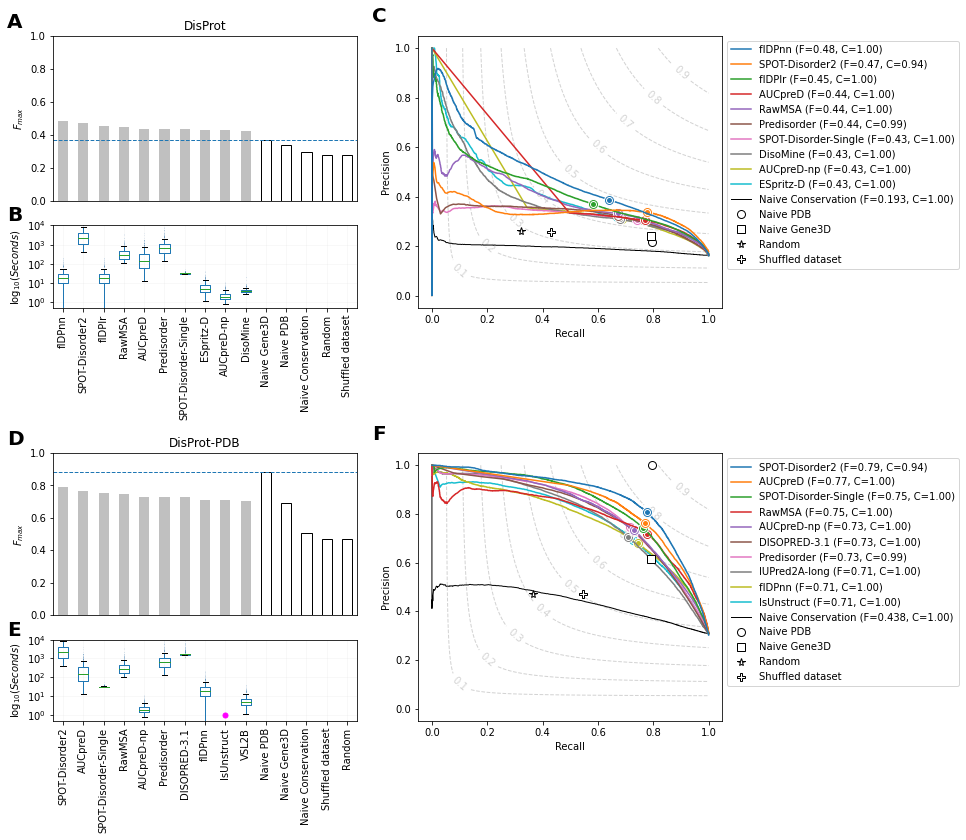

In [108]:
side = 12
fig = plt.figure(figsize=(side, side + side/20))

gs = fig.add_gridspec(2, 2, height_ratios=[2,1], bottom=0.58, wspace=0.2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:2, 1])
gs = fig.add_gridspec(2, 2, height_ratios=[2,1], top=0.42, wspace=0.2)
ax4 = fig.add_subplot(gs[0, 0], sharey=ax1)
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[:2, 1])


plot_bars(ax1, *get_bar_data_dataset('disprot-disorder', excluded_methods_disorder), '$F_{max}$', 'DisProt', 'A')
plot_cput(ax2, get_bar_data_dataset('disprot-disorder', excluded_methods_disorder)[0].index, 'B')
plot_pr(ax3, 'disprot-disorder', excluded_methods_disorder, 'C')
plot_bars(ax4, *get_bar_data_dataset('disprot-disorder-pdb-atleast', excluded_methods_disorder), '$F_{max}$', 'DisProt-PDB', 'D')
plot_cput(ax5, get_bar_data_dataset('disprot-disorder-pdb-atleast', excluded_methods_disorder)[0].index, 'E')
plot_pr(ax6, 'disprot-disorder-pdb-atleast', excluded_methods_disorder, 'F')
plt.savefig("../manuscript/fig2.png", dpi=300, bbox_inches='tight')

## Display element 3 - AUC and ROC curves
ROC curve of the best 10 ranking methods (ranking is based on ROC AUC) and baselines. X axis is 1-specificity; Y axis is sensitivity.

In [96]:
def get_auc_data(dataset, excluded_methods):
    pauc = pd.DataFrame.from_records(pd.read_csv("../results/{}.analysis.all.dataset._.roc.csv".format(dataset), 
                                          index_col=[0], 
                                          header=[0,1,2]).columns.droplevel(2).tolist(), columns=['method', 'y']
                             ).set_index('method').rename(names).astype(float).sort_values('y', ascending=False).assign(err=0)
    pauc = pauc.loc[~pauc.index.duplicated(keep='first')].drop(excluded_methods).head(10)
    cauc = pd.DataFrame.from_records(pd.read_csv("../baseline/{}.cons.all.dataset._.roc.csv".format(dataset), 
                                          index_col=[0],
                                          header=[0,1,2]).columns.droplevel(2).tolist(), columns=['method', 'y']
                             ).set_index('method').rename(names).astype(float).sort_values('y', ascending=False).assign(err=0)
    cauc = cauc.loc[~cauc.index.duplicated(keep='first')]
    gauc = pd.DataFrame.from_records(pd.read_csv("../baseline/{}.naive-gene3d-reverse.all.dataset._.roc.csv".format(dataset), 
                                          index_col=[0],
                                          header=[0,1,2]).columns.droplevel(2).tolist(), columns=['method', 'y']
                             ).set_index('method').rename(names).astype(float).sort_values('y', ascending=False).assign(err=0)
    gauc = gauc.loc[~gauc.index.duplicated(keep='first')]
    
    pdbauc = pd.DataFrame.from_records(pd.read_csv("../baseline/{}.naive-pdb-atleast-reverse.all.dataset._.roc.csv".format(dataset), 
                                          index_col=[0],
                                          header=[0,1,2]).columns.droplevel(2).tolist(), columns=['method', 'y']
                             ).set_index('method').rename(names).astype(float).sort_values('y', ascending=False).assign(err=0)
    pdbauc = pdbauc.loc[~pdbauc.index.duplicated(keep='first')]
    
    
    bauc = cauc.append(gauc).append(pdbauc)
    bauc.loc[names('random')] = [0.5, 0]
    bauc.loc[names('shuffledataset')] = [0.5, 0]
    
    return pauc.append(bauc.sort_values('y', ascending=False)), bauc.values.max()

In [99]:
def plot_roc(ax, dataset, excluded_methods, plotlbl):
    procs = pd.read_csv("../results/{}.analysis.all.dataset._.roc.csv".format(dataset), index_col=[0], header=[0,1,2]).rename(names, axis=1, level=0).drop(excluded_methods, axis=1, level=0)
    proc = pd.read_csv("../baseline/{}.naive-pdb-atleast-reverse.all.dataset._.roc.csv".format(dataset), index_col=[0], header=[0,1,2])
    groc = pd.read_csv("../baseline/{}.naive-gene3d-reverse.all.dataset._.roc.csv".format(dataset), index_col=[0], header=[0,1,2])
    croc = pd.read_csv("../baseline/{}.cons.all.dataset._.roc.csv".format(dataset), index_col=[0], header=[0,1,2])
    
    cov = pd.read_csv('../results/{}.analysis.all.target.default.metrics.csv'.format(dataset), index_col=[0,1], header=[0,1])
    cov = (cov.groupby(level=0).count().max(axis=1) / np.max(cov.groupby(level=0).count().values))
    
        # plot f-score level lines
    r = np.linspace(0, 1, 1000)
    fs = np.mean(np.array(np.meshgrid(r, r)).T.reshape(-1, 2), axis=1).reshape(1000, 1000)
    cs = ax.contour(r[::-1], r, fs, levels=np.linspace(0.1, 1, 10), colors='silver', alpha=0.7, linewidths=1, linestyles='--')
    ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10, manual=[(l, 1-l) for l in cs.levels[:-1]])
    
    auc_rocs = sorted(procs.columns.droplevel(2).unique(), key=lambda t: t[1], reverse=True)[:10]
    rocs = procs.reindex(list(zip(*auc_rocs))[0], axis=1, level=0)
#     ax.plot([0, 1], [0, 1], color='k', linestyle='--')
    for p in rocs.columns.get_level_values(0).unique()[:10]:
        ax.plot(*rocs[p].dropna().T.values, label=p)
    
    
    ax.plot(*croc.values.T, label="Naive Conservation", color='k', linewidth=1)
    cov['Naive Conservation'] = 1

    for n, m in zip([proc, groc], ['o', 's']):
        idx = n.index.values - 0.5
        ax.plot(*n.loc[1.0], marker=m, markeredgecolor='k', markeredgewidth=1, markerfacecolor='w', markersize=8, 
                     c='w', label=names(n.columns.get_level_values(0)[0]))

    for b, m in zip(['random', 'shuffledataset'], ['*', 'P', 'd']):
        ax.plot(*pd.read_csv('../baseline/{}.{}.all.target.mcc.metrics.csv'.format(dataset, b), index_col=0)[['fpr', 'tpr']].mean(), 
                     marker=m, markeredgecolor='k', markeredgewidth=1, markerfacecolor='w', markersize=8, 
                     c='w', label=names(b))
    
    cov = cov.rename(names).round(2).to_dict()
    ax.legend()
    lhandles, llabels = ax.get_legend_handles_labels()
    auc_rocs.extend(croc.rename(names, axis=1, level=0).columns.droplevel(2).unique().tolist())
    
    pwauc = next(zip(*auc_rocs))
    ax.legend(lhandles, ['{}'.format('{} (A={}, C={})'.format(l, auc_rocs[pwauc.index(l)][1], cov[l]) if l in pwauc else l) for l in llabels],
            loc='upper left', bbox_to_anchor=(1, 1))#, ncol=2, mode="expand", borderaxespad=0., fontsize=9.4)
    
    ax.text(-0.15, 1.05, plotlbl, transform=ax.transAxes, size=20, weight='bold')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    
# fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
# plot_pred_and_bases_rocs(axes[0], roc_simple_preds, roc_simple_npdbr, roc_simple_ngen3, 'disprot-disorder', 'DisProt', names, roc_simple_ncons)
# plot_pred_and_bases_rocs(axes[1], roc_pdb_preds, roc_pdb_npdbr, roc_pdb_ngen3, 'disprot-disorder-pdb-atleast', 'DisProt-PDB', names, roc_pdb_ncons)
# plt.savefig("../manuscript/fig3.png", dpi=300, bbox_inches="tight")

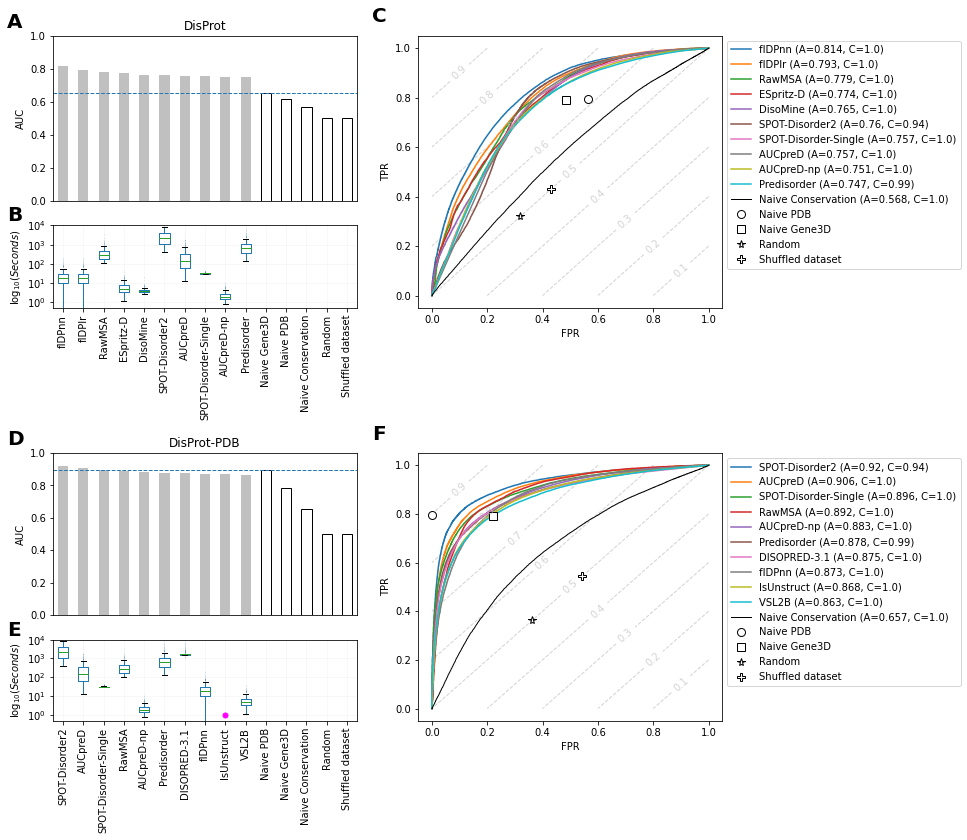

In [100]:
side = 12
fig = plt.figure(figsize=(side, side + side/20))

gs = fig.add_gridspec(2, 2, height_ratios=[2, 1], bottom=0.58, wspace=0.2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:2, 1])
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1], top=0.42, wspace=0.2)
ax4 = fig.add_subplot(gs[0, 0], sharey=ax1)
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[:2, 1])

plot_bars(ax1, *get_auc_data('disprot-disorder', excluded_methods_disorder), 'AUC', 'DisProt', 'A')
plot_cput(ax2, get_auc_data('disprot-disorder', excluded_methods_disorder)[0].index, 'B')
plot_roc(ax3, 'disprot-disorder', excluded_methods_disorder, 'C')
plot_bars(ax4, *get_auc_data('disprot-disorder-pdb-atleast', excluded_methods_disorder), 'AUC', 'DisProt-PDB', 'D')
plot_cput(ax5, get_auc_data('disprot-disorder-pdb-atleast', excluded_methods_disorder)[0].index, 'E')
plot_roc(ax6, 'disprot-disorder-pdb-atleast', excluded_methods_disorder, 'F')
gs.tight_layout(fig, rect=(1, 1, 1, 1))
plt.savefig("../manuscript/fig3.png", dpi=300, bbox_inches='tight')

## Display element 4 - Fully ID table
Performance of predictors (shown as confusion matrix) on their ability to discriminate fully disordered proteins (>95% id content) from non-fully disordered proteins.

In [31]:
predictions = pd.read_csv(caidfolder / "results/disprot-disorder.analysis.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_cons = pd.read_csv(caidfolder / "baseline/disprot-disorder.cons.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_pdbr = pd.read_csv(caidfolder / "baseline/disprot-disorder.naive-pdb-atleast-reverse.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_gene3dr = pd.read_csv(caidfolder / "baseline/disprot-disorder.naive-gene3d-reverse.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
predictions = pd.DataFrame({**predictions.to_dict(), **baseline_cons.to_dict(), **baseline_pdbr.to_dict(), **baseline_gene3dr.to_dict()}).dropna()

In [32]:
idcontent_ref = predictions[("ref", "states")].groupby(level=0).mean()
idcontent_pred = predictions.groupby(level=0).mean()

In [33]:
def id_content_table(idc_pred, fullid_thr=0.95):
    fullid = (idc_pred.xs("states", axis=1, level=1).round(3) > fullid_thr).astype(int)
    fullid_r = fullid["ref"].astype(int)
    fullid_p = fullid.astype(int).drop("ref", axis=1)
    fullid_table = fullid.apply(lambda s: mtr.confusion_matrix(fullid_r.values, s.values, labels=[0, 1]).ravel())
    fullid_table.index = ["tn", "fp", "fn", "tp"]
    fullid_table = fullid_table.T
    fullid_table = fullid_table.assign(mcc=fullid.apply(lambda s: mtr.matthews_corrcoef(fullid_r.values, s.values)))
    fullid_table = fullid_table.assign(f1s=fullid.apply(lambda s: mtr.f1_score(fullid_r.values, s.values)))
    fullid_table = fullid_table.assign(tnr=fullid.apply(lambda s: mtr.classification_report(fullid_r.values, s.values, output_dict=True)['0']['recall']))
    fullid_table = fullid_table.assign(tpr=fullid.apply(lambda s: mtr.classification_report(fullid_r.values, s.values, output_dict=True)['1']['recall']))
    fullid_table = fullid_table.assign(ppv=fullid.apply(lambda s: mtr.classification_report(fullid_r.values, s.values, output_dict=True)['1']['precision']))
    fullid_table = fullid_table.assign(bac=fullid.apply(lambda s: mtr.balanced_accuracy_score(fullid_r.values, s.values)))
    fullid_table = fullid_table.drop("ref").sort_values(by="f1s", ascending=False).rename(names).round(3)
    fullid_table.columns = pd.MultiIndex.from_product([['DisProt-Full-ID (IDC>{}%)'.format(int(fullid_thr*100))], fullid_table.columns])
    return fullid_table

for t in [0.80, 0.90, 0.95, 0.99]:
    id_content_table(idcontent_pred, t).to_csv("../manuscript/disprot-disorder.fullid.{}.csv".format(int(t*100)), float_format='%.3f')
    
id_content_table(idcontent_pred, 0.95)

DisProt-Full-ID (IDC>95%)                             \
                                            tn   fp  fn  tp    mcc    f1s   
fIDPnn                                     527   16  15  26  0.598  0.627   
RawMSA                                     524   19  15  26  0.574  0.605   
VSL2B                                      520   23  18  23  0.492  0.529   
Predisorder                                531   12  22  19  0.503  0.528   
fIDPlr                                     508   35  14  27  0.493  0.524   
IUPred-long                                537    6  26  15  0.487  0.484   
AUCpreD                                    530   13  24  17  0.452  0.479   
SPOT-Disorder1                             514   29  19  22  0.437  0.478   
SPOT-Disorder-Single                       536    7  26  15  0.474  0.476   
SPOT-Disorder2                             516   27  20  21  0.430  0.472   
DisoMine                                   493   50  13  28  0.444  0.471   
IsUnstruct                                 530   13  25  16  0.431  0.457   
IUPred2A-long                              537    6  28  13  0.441  0.433   
Naive Gene3D                               462   81   8  33  0.423  0.426   
ESpritz-N                                  539    4  29  12  0.447  0.421   
PyHCA                                      538    5  29  12  0.431  0.414   
MobiDB-lite                                541    2  30  11  0.458  0.407   
JRONN                                      537    6  29  12  0.416  0.407   
ESpritz-D                                  497   46  19  22  0.360  0.404   
IUPred-short                               542    1  31  10  0.455  0.385   
IUPred2A-short                             541    2  31  10  0.433  0.377   
DisPredict-2                               528   15  28  13  0.346  0.377   
S2D-2                                      514   29  26  15  0.302  0.353   
Naive PDB                                  428  115  10  31  0.321  0.332   
AUCpreD-np                                 532   11  31  10  0.307  0.323   
ESpritz-X                                  537    6  32   9  0.337  0.321   
S2D-1                                      491   52  25  16  0.235  0.294   
FoldUnfold                                 398  145  10  31  0.272  0.286   
DISOPRED-3.1                               538    5  35   6  0.258  0.231   
DisEMBL-HL                                 543    0  37   4  0.302  0.178   
DisEMBL-465                                543    0  39   2  0.213  0.093   
Naive Conservation                         407  136  35   6 -0.062  0.066   
DFLpred                                    543    0  41   0  0.000  0.000   
GlobPlot                                   543    0  41   0  0.000  0.000   
DynaMine                                   543    0  41   0  0.000  0.000   

                                                  
                        tnr    tpr    ppv    bac  
fIDPnn                0.971  0.634  0.619  0.802  
RawMSA                0.965  0.634  0.578  0.800  
VSL2B                 0.958  0.561  0.500  0.759  
Predisorder           0.978  0.463  0.613  0.721  
fIDPlr                0.936  0.659  0.435  0.797  
IUPred-long           0.989  0.366  0.714  0.677  
AUCpreD               0.976  0.415  0.567  0.695  
SPOT-Disorder1        0.947  0.537  0.431  0.742  
SPOT-Disorder-Single  0.987  0.366  0.682  0.676  
SPOT-Disorder2        0.950  0.512  0.438  0.731  
DisoMine              0.908  0.683  0.359  0.795  
IsUnstruct            0.976  0.390  0.552  0.683  
IUPred2A-long         0.989  0.317  0.684  0.653  
Naive Gene3D          0.851  0.805  0.289  0.828  
ESpritz-N             0.993  0.293  0.750  0.643  
PyHCA                 0.991  0.293  0.706  0.642  
MobiDB-lite           0.996  0.268  0.846  0.632  
JRONN                 0.989  0.293  0.667  0.641  
ESpritz-D             0.915  0.537  0.324  0.726  
IUPred-short          0.998  0.244  0.909  0.621  
IUPred2A-short        0.996  0.244  0.833  0.620 

In [34]:
df = predictions.groupby(level=0).mean().xs("states", level=1, axis=1).rename(names, axis=1)
# set(df["Naive Gene3D"][df["Naive Gene3D"] > 0.95].index) - set(df["Naive PDB"][df["Naive PDB"] > 0.95].index)

## Display element 5 - Binding
MCC and ROC curve for binding

In [101]:
metrics_simple_target_preds_binding = pd.read_csv(caidfolder / "results/disprot-binding.analysis.all.target.f1s.metrics.csv", index_col=[0, 1]).rename(names, level=0)
metrics_simple_target_npdbr_binding = pd.read_csv(caidfolder / "baseline/disprot-binding.naive-pdb-atleast-reverse.all.target.f1s.metrics.csv", index_col=[0, 1])
metrics_simple_target_ngen3_binding = pd.read_csv(caidfolder / "baseline/disprot-binding.naive-gene3d-reverse.all.target.f1s.metrics.csv", index_col=[0, 1])
# metrics_simple_target_nfixf_binding = pd.read_csv(caidfolder / "baseline/disprot-binding.fixedposfrc.all.target.mcc.metrics.csv", index_col=[0, 1])

In [102]:
mcc_simple_targetavg_preds_binding = metrics_simple_target_preds_binding.f1s.groupby(level=0).describe()[["mean", "std"]].sort_values("mean",ascending=False)

mcc_simple_targetavg_base_binding = pd.concat(
    [metrics_simple_target_ngen3_binding["f1s"].describe()[["mean", "std"]].to_frame().T.rename({"f1s": "Naive Gene3D"}),
     metrics_simple_target_npdbr_binding["f1s"].describe()[["mean", "std"]].to_frame().T.rename({"f1s": "Naive PDB"}),
#      metrics_simple_target_nfixf_binding["mcc"].describe()[["mean", "std"]].to_frame().T.rename({"mcc": "Fixed ID content"})
    ], sort=False).sort_values("mean", ascending=False)

mcc_simple_plot_data_binding = mcc_simple_targetavg_preds_binding.head(10).drop('ANCHOR').append(mcc_simple_targetavg_base_binding)


In [103]:
roc_simple_preds_binding = pd.read_csv(caidfolder / "results/disprot-binding.analysis.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
roc_simple_npdbr_binding = pd.read_csv(caidfolder / "baseline/disprot-binding.naive-pdb-atleast-reverse.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
roc_simple_ngen3_binding = pd.read_csv(caidfolder / "baseline/disprot-binding.naive-gene3d-reverse.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
# roc_simple_ncons = pd.read_csv("../baseline/new-disprot-all_simple.cons.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])

In [104]:
# create auc ranking of all predictor + baselines
roc_simple_preds_binding = roc_simple_preds_binding.drop("B001_ANCHOR", axis=1, level=0)
auc_simple = sorted(roc_simple_preds_binding.join(roc_simple_npdbr_binding).join(roc_simple_ngen3_binding).columns.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
# select first 10 predictors 
roc_simple = roc_simple_preds_binding.reindex(list(zip(*auc_simple))[0], axis=1, level=0).T.head(20)
# add baselines if they are not among the best 10
roc_simple = roc_simple.append(roc_simple_npdbr_binding.T) if roc_simple_npdbr_binding.index.get_level_values(0)[0] not in roc_simple.index.get_level_values('predictor').unique() else roc_simple
roc_simple = roc_simple.append(roc_simple_ngen3_binding.T) if roc_simple_ngen3_binding.index.get_level_values(0)[0] not in roc_simple.index.get_level_values('predictor').unique() else roc_simple
# roc_simple = roc_simple.append(roc_simple_ncons.T) if roc_simple_ncons.index.get_level_values(0)[0] not in roc_simple.index.get_level_values('predictor').unique() else roc_simple
# recreate auc ranking with first 10 predictors and baselines

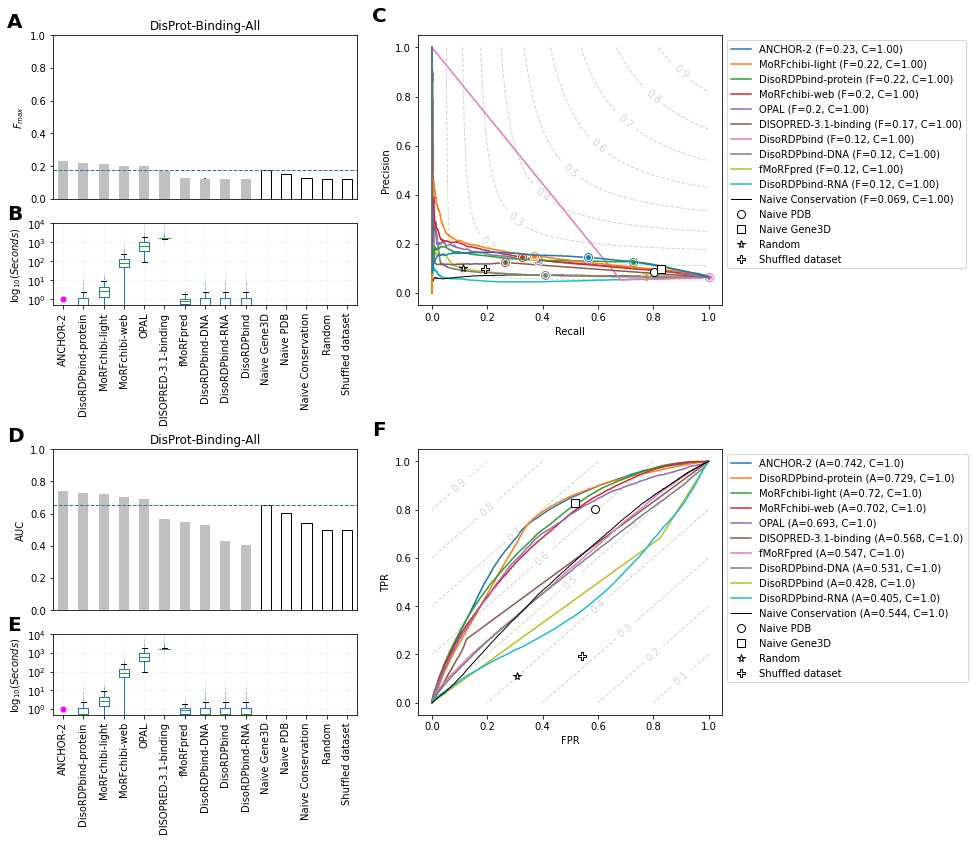

In [109]:
fig = plt.figure(figsize=(12, 12.5))

gs = fig.add_gridspec(2, 2, height_ratios=[2, 1], bottom=0.58, wspace=0.2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:2, 1])
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1], top=0.42, wspace=0.2)
ax4 = fig.add_subplot(gs[0, 0], sharey=ax1)
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[:2, 1])

plot_bars(ax1, *get_bar_data_dataset('disprot-binding-all', excluded_methods_binding), '$F_{max}$', 'DisProt-Binding-All', 'A')
plot_cput(ax2, get_bar_data_dataset('disprot-binding-all', excluded_methods_binding)[0].index, 'B')
plot_pr(ax3, 'disprot-binding-all', excluded_methods_binding, 'C')
plot_bars(ax4, *get_auc_data('disprot-binding-all', excluded_methods_binding), 'AUC', 'DisProt-Binding-All', 'D')
plot_cput(ax5, get_auc_data('disprot-binding-all', excluded_methods_binding)[0].index, 'E')
plot_roc(ax6, 'disprot-binding-all', excluded_methods_binding, 'F')
gs.tight_layout(fig, rect=(1, 1, 1, 1))
plt.savefig("../manuscript/fig4.png", dpi=300, bbox_inches='tight')

In [40]:
(metrics_simple_target_preds_binding.f1s.groupby(level=0).count().reindex(metrics_simple_target_preds_binding.f1s.groupby(level=0).mean().sort_values(ascending=False).index) / 231 * 100).round(1)

DisoRDPbind-protein     100.0
OPAL                     99.6
MoRFchibi-web            99.6
MoRFchibi-light          99.6
DisoRDPbind             100.0
DisoRDPbind-RNA         100.0
DisoRDPbind-DNA         100.0
ANCHOR-2                100.0
fMoRFpred               100.0
ANCHOR                  100.0
DISOPRED-3.1-binding    100.0
Name: f1s, dtype: float64